# A normal distribution sampler in python

Last year, I had the pleasure of attending a tutorial with the great [Petros Dellaportas](http://www.homepages.ucl.ac.uk/~ucakpde/#), a one-day primer in bayesian inference. One of the main sessions was about Markov chain Monte Carlo sampling, the technique whose name inspired one of the all-time greatest blog names (and blogs) ever: ['While my MCMC gently samples'](https://twiecki.io/)... and _also_ a game-changing statistical insight when it comes to sampling from complex statistical distributions. Following the session, I caught up with Petros and asked a pretty useful question, but pretty revealing question: 

<p><center>'So, I kind of understand MCMC now... but why does it matter?!'</center></p>

Petros being Petros, he was more than equal to my question:

<p><center>'MCMC is a tool to sample from complex distributions. Let's start with a simple distribution, the Normal Distribution. After this session, go and write a normal distribution sampler. Then, go and look up the Box-Mueller method, and you'll realise that MCMC matters - effective sampling from distributions is not trivial!</center></p>

So, here's my naive attempt. Further down, we'll see how limiting it is, and how we can do better. 

In [1]:
import numpy as np
from numpy.random import rand

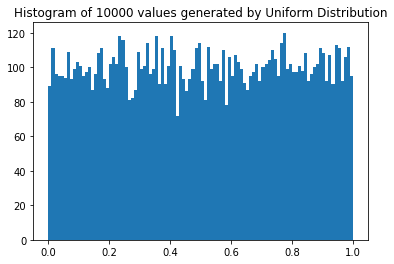

In [2]:
## testing out the random.rand function to set some tests for our proposed solution

import matplotlib.pyplot as plt
%matplotlib inline 
n = 10000

test_set = rand(n)

plt.hist(test_set, bins=100)  
plt.title("Histogram of %i values generated by Uniform Distribution" %(n))
plt.show()

The probability density function of the normal distribution is defined as:

$$ f(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma ^2}}e ^ {- \frac{(x-\mu)^2}{2\sigma^2}}  $$

In [4]:
from math import pi

def norm(x_array, m, s):
    point_array = 1/np.sqrt(2* pi * s ** 2) * np.exp((-(x_array - mu)**2)/2*s**2)
    return(point_array)

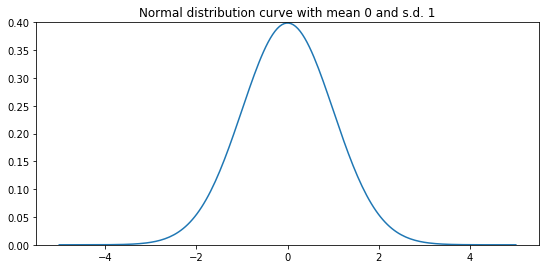

In [5]:
sigma = 1
mu = 0

x = np.linspace(-5,5,200)
y = norm(x, mu, sigma)


fig = plt.figure(figsize=(9,9))

n_axes = fig.add_subplot(211)

n_axes.set_autoscaley_on(False)
n_axes.set_ylim([0,0.4])

n_axes.plot(x, y)
plt.title("Normal distribution curve with mean %i and s.d. %i" %(mu, sigma))
plt.show()

Now, if we want to sample from this probability density function so that $$ X \sim N(0, 1) $$, we need to calculate the area under the curve. Given an interval, we can calculate the y values at the beginning and end of the interval, then we use the trapezium rule $$ \frac{1}{2} * (a + b) * width $$ to get the area of this slice. Given the area of each section and the total number of samples we want, we can calculate how many uniformly distributed samples we want to take from each interval, and thus give us a normal distribution from which to sample.



In [7]:
sigma = 1
mu = 0


x_int = np.array([0,0.25])
x_width = x_int.max() - x_int.min()
y_vals = norm(x_int, mu, sigma)
area = 0.5 * y_vals.sum()*x_width

print(y_vals)
print(area)

[0.39894228 0.38666812]
0.09820129965053524


In [8]:
## function to calculate the trapezium area

def trap_area(y1, y2, width):
    return 0.5*(y1 + y2)* width

trap_area(*y_vals, x_width)

0.09820129965053524

In [18]:
sigma = 1
mu = 0

## set our full interval to be 4 s.d. from the mean
## so with X~(0,1) we'll get an interval of (-4, 4)

interval = np.array([mu - sigma*4,mu+sigma*4])

## split this into k strips, which will control how fine-grain our slices are (let's say k = 80, intervals of 0.1)
k = 80
strip_width = (interval[1]-interval[0])/k

sub_strips = np.linspace(*interval, k + 1) ## 81 edges gives 80 strips
sub_strips_pairs = [np.array([sub_strips[p],sub_strips[p+1]]) for p in range(80)]


## also set how many samples we want 
n = 10000

## the area of the strip tells us how many values we want to select, as a proportion of n
## create an array of areas

areas = np.array([trap_area(*norm(s, mu, sigma),0.1) for s in sub_strips_pairs])

print(areas.sum()) ## we can live with a probability that is roughly equal to 1



0.9999357672440047


In [19]:
## sense check


##  we can generate these using a uniformly distributed rv within that interval
bin_counts = np.round(areas * n)


x = bin_counts[30]
interval = sub_strips_pairs[30]
width = interval[1] - interval[0]

print("%i values in the interval (%f,%f)" %(x, *interval))
p = rand(int(x))*width + interval[0]

254 values in the interval (-1.000000,-0.900000)


In [54]:
bin_counts

array([  0.,   0.,   0.,   1.,   1.,   1.,   1.,   2.,   3.,   4.,   5.,
         7.,   9.,  12.,  16.,  20.,  25.,  32.,  40.,  49.,  60.,  72.,
        86., 102., 120., 140., 161., 183., 206., 230., 254., 278., 301.,
       323., 343., 360., 375., 386., 394., 398., 398., 394., 386., 375.,
       360., 343., 323., 301., 278., 254., 230., 206., 183., 161., 140.,
       120., 102.,  86.,  72.,  60.,  49.,  40.,  32.,  25.,  20.,  16.,
        12.,   9.,   7.,   5.,   4.,   3.,   2.,   1.,   1.,   1.,   1.,
         0.,   0.,   0.])

In [20]:
normal_sample = np.array([])

for i in range(k):
    count = bin_counts[i]
    strip = sub_strips_pairs[i]
    sample = rand(int(count)) * width + strip[0]
    normal_sample = np.append(normal_sample, sample)
    
len(normal_sample) ## ok, so we gained a couple of samples, but nothing to worry about

10000

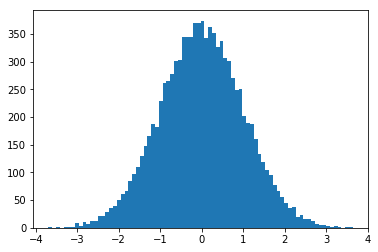

In [21]:
plt.hist(normal_sample, bins = 80)
plt.show()

In [53]:
## Now that we have a normally distributed sample, we can just make a uniformly random selection from this array


normal_sample[np.random.randint(len(normal_sample))]

-0.8679602426004758

Let's wrap this code up, and put it through its paces.

In [18]:
#TODO

# Wrap Normal dist code into a class, with parameter k (number of bins) 

# test implementation with increasing accuracy, show that its slow 

# Start the box_mueller implementation